In [3]:
import pandas as pd
pd.read_csv('nifty_option_chain.csv')

,strike,expiry,CE_lastPrice,CE_bid,CE_ask,PE_lastPrice,PE_bid,PE_ask
0,16000,30-Dec-25,10090.00,10057.20,10584.65,1.50,1.50,1.75
1,17000,30-Dec-25,9305.00,9305.10,9390.40,1.70,1.55,1.70
2,18000,30-Dec-25,8375.25,8271.90,8396.00,2.15,1.90,2.15
3,19000,30-Dec-25,7140.00,7191.70,7430.05,11.00,3.00,8.35
4,20000,30-Dec-25,6360.00,6348.25,6388.10,3.75,3.75,3.80
...,...,...,...,...,...,...,...,...
109,27950,30-Dec-25,0.00,22.90,26.80,1556.85,1415.30,1835.80
110,28000,30-Dec-25,9.00,8.55,9.00,1596.00,1590.00,1596.00
111,29000,30-Dec-25,3.80,3.45,3.85,2596.05,2558.55,2592.60
112,30000,30-Dec-25,2.50,2.10,2.50,3577.00,3564.30,3584.35


Running Monte Carlo pricing for Heston and Black-Scholes (σ_BS = 20%)...
Processing strike: 30,500
Heston vs Black-Scholes (σ_BS = 20%) vs Intrinsic - 30 Days Expiry
 Strike  Moneyness  Heston_Call  BS_Call  Intrinsic_Call  Heston_Put  BS_Put  Intrinsic_Put  IV_Heston_Call_%  IV_Heston_Put_%  IV_BS_Call_%  IV_BS_Put_%
  16000      0.615     10122.20 10127.28         10032.2        0.00    0.00            0.0               NaN              NaN         62.52          NaN
  16500      0.634      9625.06  9630.15          9532.2        0.00    0.00            0.0               NaN              NaN         58.90          NaN
  17000      0.653      9127.93  9133.02          9032.2        0.00    0.00            0.0               NaN              NaN         55.38          NaN
  17500      0.672      8630.80  8635.89          8532.2        0.00    0.00            0.0               NaN              NaN         51.95          NaN
  18000      0.691      8133.67  8138.76          8032.2        

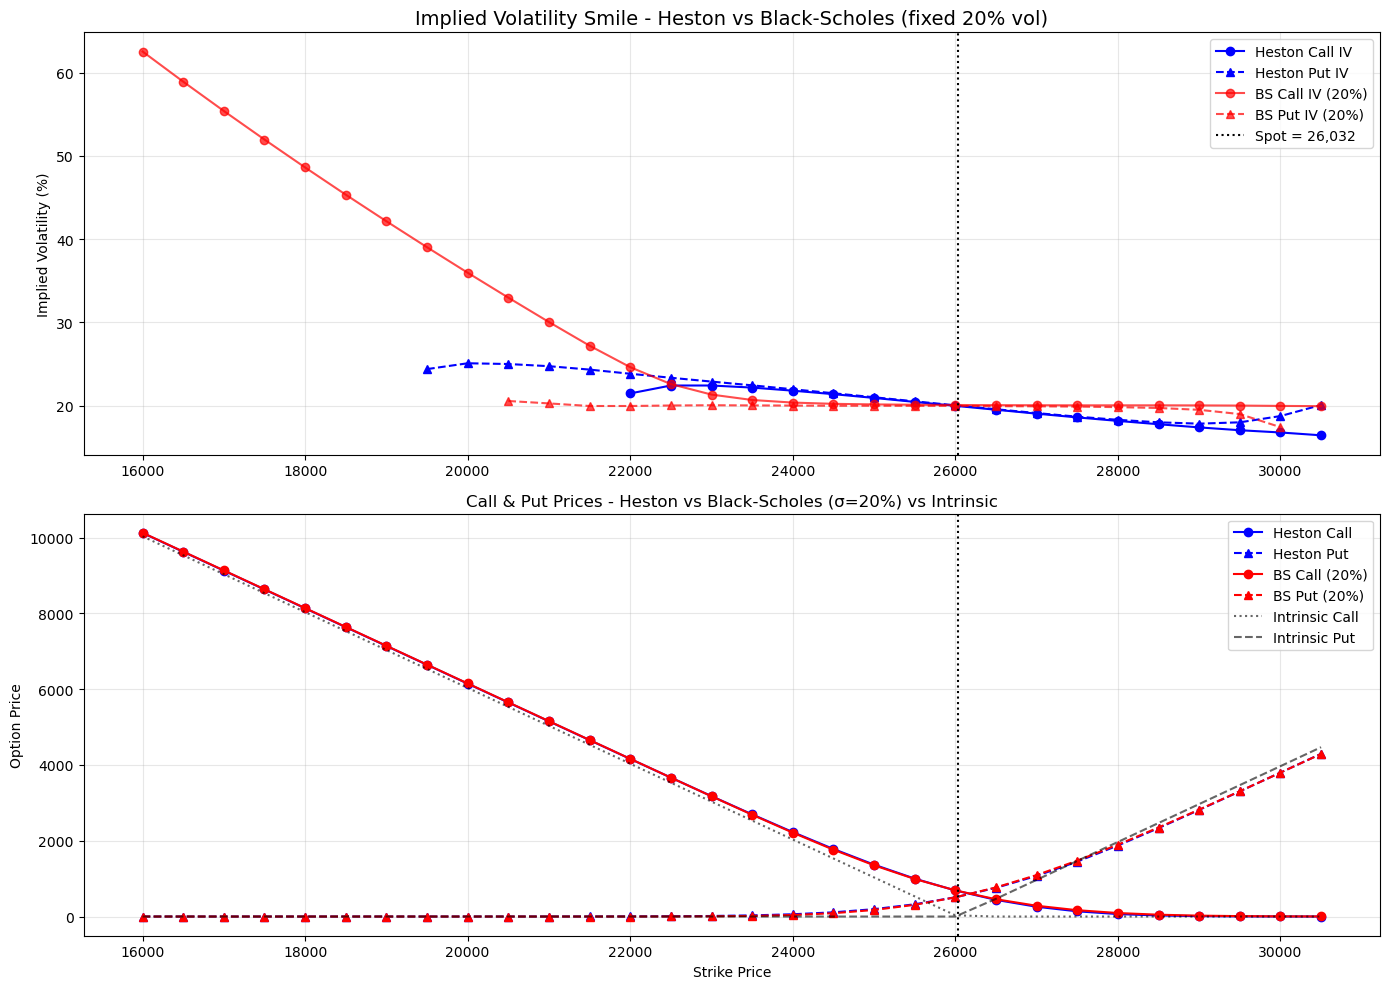


Done! Now Black-Scholes uses exactly 20% constant volatility.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# =============================
# Black-Scholes Closed Form (for IV)
# =============================
def bs_price(S, K, T, r, sigma, type="call"):
    if T <= 0:
        payoff = max(S - K, 0) if type == "call" else max(K - S, 0)
        return payoff * np.exp(-r * T)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# =============================
# Robust Implied Volatility
# =============================
def implied_vol(price, S, K, T, r, type="call"):
    if price <= 0:
        return np.nan
    def objective(sigma):
        return bs_price(S, K, T, r, sigma, type) - price
    try:
        return brentq(objective, 1e-6, 5.0, xtol=1e-8, maxiter=100)
    except:
        return np.nan

# =============================
# Heston Monte Carlo (Full Truncation - Stable)
# =============================
def heston_simulate(S0, v0, kappa, theta, sigma_v, rho, r, T, steps=50, paths=120000, seed=42):
    np.random.seed(seed)
    dt = T / steps
    S = np.full(paths, S0)
    v = np.full(paths, v0)
    for _ in range(steps):
        Z1 = np.random.normal(size=paths)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(size=paths)
        v_plus = np.maximum(v, 0)
        v = v_plus + kappa * (theta - v_plus) * dt + sigma_v * np.sqrt(v_plus) * np.sqrt(dt) * Z2
        v = np.maximum(v, 0)
        S = S * np.exp((r - 0.5 * v_plus) * dt + np.sqrt(v_plus) * np.sqrt(dt) * Z1)
    return S

# =============================
# Black-Scholes Monte Carlo
# =============================
def bs_simulate(S0, sigma, r, T, paths=120000, seed=42):
    np.random.seed(seed)
    Z = np.random.normal(size=paths)
    return S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

# =============================
# Parameters
# =============================
S0   = 26032.20
r    = 0.07
T    = 30 / 365.0
paths = 120000
steps = 50

# Heston Parameters (realistic equity skew)
v0      = 0.04      # initial variance
kappa   = 1.5
theta   = 0.04      # long-term variance
sigma_v = 0.3       # vol of vol
rho     = -0.7      # correlation (negative → downside skew)

# <<< CHANGED LINE >>>
sigma_bs = 0.20     # Fixed 20% volatility for Black-Scholes (instead of sqrt(v0))

# Strikes
strikes = np.arange(16000, 31000, 500)

print("Running Monte Carlo pricing for Heston and Black-Scholes (σ_BS = 20%)...")

# =============================
# Run Simulations
# =============================
results = []
for K in strikes:
    print(f"Processing strike: {K:,}", end="\r")

    # --- Heston ---
    S_heston = heston_simulate(S0, v0, kappa, theta, sigma_v, rho, r, T, steps, paths)
    heston_call = np.exp(-r*T) * np.mean(np.maximum(S_heston - K, 0))
    heston_put  = np.exp(-r*T) * np.mean(np.maximum(K - S_heston, 0))

    # --- Black-Scholes with fixed 20% vol ---
    S_bs = bs_simulate(S0, sigma_bs, r, T, paths)
    bs_call = np.exp(-r*T) * np.mean(np.maximum(S_bs - K, 0))
    bs_put  = np.exp(-r*T) * np.mean(np.maximum(K - S_bs, 0))

    # --- Intrinsic ---
    intrinsic_call = max(S0 - K, 0)
    intrinsic_put  = max(K - S0, 0)

    # --- Implied Vols ---
    iv_heston_call = implied_vol(heston_call, S0, K, T, r, "call")
    iv_heston_put  = implied_vol(heston_put,  S0, K, T, r, "put")
    iv_bs_call     = implied_vol(bs_call,     S0, K, T, r, "call")
    iv_bs_put      = implied_vol(bs_put,      S0, K, T, r, "put")

    results.append({
        'Strike': K,
        'Moneyness': round(K / S0, 3),
        'Heston_Call': round(heston_call, 2),
        'Heston_Put' : round(heston_put, 2),
        'BS_Call'    : round(bs_call, 2),
        'BS_Put'     : round(bs_put, 2),
        'Intrinsic_Call': intrinsic_call,
        'Intrinsic_Put' : intrinsic_put,
        'IV_Heston_Call_%': round(iv_heston_call * 100, 2) if not np.isnan(iv_heston_call) else np.nan,
        'IV_Heston_Put_%' : round(iv_heston_put  * 100, 2) if not np.isnan(iv_heston_put)  else np.nan,
        'IV_BS_Call_%'    : round(iv_bs_call     * 100, 2) if not np.isnan(iv_bs_call)     else np.nan,
        'IV_BS_Put_%'     : round(iv_bs_put      * 100, 2) if not np.isnan(iv_bs_put)      else np.nan,
    })

# =============================
# Output
# =============================
df = pd.DataFrame(results)
df = df[['Strike', 'Moneyness', 'Heston_Call', 'BS_Call', 'Intrinsic_Call',
         'Heston_Put', 'BS_Put', 'Intrinsic_Put',
         'IV_Heston_Call_%', 'IV_Heston_Put_%', 'IV_BS_Call_%', 'IV_BS_Put_%']]

print("\n" + "="*110)
print("Heston vs Black-Scholes (σ_BS = 20%) vs Intrinsic - 30 Days Expiry")
print("="*110)
print(df.to_string(index=False))
print("="*110)

df.to_excel("Heston_vs_BS_sigma20.xlsx", index=False)
print("\nSaved to 'Heston_vs_BS_sigma20.xlsx'")

# =============================
# Plots
# =============================
plt.figure(figsize=(14, 10))

# Implied Volatility Smile
plt.subplot(2, 1, 1)
plt.plot(df['Strike'], df['IV_Heston_Call_%'], 'bo-', label='Heston Call IV', markersize=6)
plt.plot(df['Strike'], df['IV_Heston_Put_%'],  'b^--', label='Heston Put IV', markersize=6)
plt.plot(df['Strike'], df['IV_BS_Call_%'],     'ro-', alpha=0.7, label='BS Call IV (20%)')
plt.plot(df['Strike'], df['IV_BS_Put_%'],      'r^--', alpha=0.7, label='BS Put IV (20%)')
plt.axvline(S0, color='black', linestyle=':', label=f'Spot = {S0:,.0f}')
plt.title('Implied Volatility Smile - Heston vs Black-Scholes (fixed 20% vol)', fontsize=14)
plt.ylabel('Implied Volatility (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Option Prices
plt.subplot(2, 1, 2)
plt.plot(df['Strike'], df['Heston_Call'], 'bo-', label='Heston Call')
plt.plot(df['Strike'], df['Heston_Put'],  'b^--', label='Heston Put')
plt.plot(df['Strike'], df['BS_Call'],     'ro-', label='BS Call (20%)')
plt.plot(df['Strike'], df['BS_Put'],      'r^--', label='BS Put (20%)')
plt.plot(df['Strike'], df['Intrinsic_Call'], 'k:', alpha=0.6, label='Intrinsic Call')
plt.plot(df['Strike'], df['Intrinsic_Put'],  'k--', alpha=0.6, label='Intrinsic Put')
plt.axvline(S0, color='black', linestyle=':')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Call & Put Prices - Heston vs Black-Scholes (σ=20%) vs Intrinsic')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDone! Now Black-Scholes uses exactly 20% constant volatility.")